# Setups

## Download Projects and Dependencies

In [ ]:
!sudo apt install git-lfs
!git clone https://github.com/MMintLab/VIRDO.git

!pip install open3d==0.14.1
!pip install torch==1.10.0+cu111
!pip install plyfile==0.7.4
!python -m pip install git+https://github.com/krrish94/chamferdist.git

  Created wheel for chamferdist: filename=chamferdist-1.0.0-cp37-cp37m-linux_x86_64.whl size=7188902 sha256=f8fac9f3ddd42a9a8cd5a4fd2d64fc3cd77f47ddcc58ec35c3b0a04c7a44beb8
  Stored in directory: /tmp/pip-ephem-wheel-cache-6alkl4qk/wheels/f5/26/f5/dba0a210a1c22300c32760c967b180ccdb5a96f7a7e7fc39e2
Successfully built chamferdist


In [48]:
import os
os.chdir('VIRDO')
!git checkout working
!git pull

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/MMintLab/VIRDO
   8ca3798..2f7d1f1  working    -> origin/working
Updating 8ca3798..2f7d1f1
Fast-forward
 modules.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


## Download Data/Pretrained models

In [ ]:
os.chdir('data')
!curl https://www.dropbox.com/sh/1q4o86az3sj6xgr/AAD325-PcxYKV7FKAEBI1QoLa?dl=0 -L -O -J
!unzip -o data.zip virdo_simul_dataset.pickle

!curl https://www.dropbox.com/sh/tuu7qsdjgpgimz4/AAB6rUjMohIBDk7aT1Fbyt1ka?dl=0 -L -O -J
!unzip -o pcd_occlusion.zip

os.chdir('../pretrained_model')
!curl https://www.dropbox.com/sh/s1r9gxd9dz4wdkk/AADK6mHvrPtFYo_xD4EmZZdda?dl=0 -L -O -J
!unzip -o pretrained_model.zip
os.chdir('..')

# Load Training Data

In [ ]:
import sys, torch, random
from torch.utils.data import DataLoader
from importlib import reload

## Directories
root_path = os.getcwd()
model_directory = os.path.join(root_path, 'pretrained_model')
sys.path.append(root_path)

DEVICE = 'cuda'

In [ ]:
import pickle
with open('data/virdo_simul_dataset.pickle', 'rb') as f:
  data_dict = pickle.load(f)

In [ ]:
### Pair Object code and Force code
import open3d as o3d
import numpy as np
pairs = {}
data = data_dict['train']
for obj_idx in data: 
    pairs[obj_idx] = []
    for deform_idx in data[obj_idx]:
        if deform_idx != 'nominal':
            pairs[obj_idx].append(deform_idx)
print(pairs)

{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 1: [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], 2: [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71], 3: [72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], 4: [96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119], 5: [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]}


In [57]:
## Example of partial pointclouds
occ_file_list = ['o0_d9.ply'] 
occ_data_dict = {}
for f in occ_file_list: 
  obj_idx, def_idx = f.split('.')[0].split('_')
  obj_idx = int(obj_idx[1:])
  def_idx = int(def_idx[1:])

  occ_pcd = torch.tensor(np.array(o3d.io.read_point_cloud('data/'+ f).points)).float()

  occ_data_dict[obj_idx] = {def_idx : {'reaction' : data[obj_idx][def_idx]['reaction'],
                                   'coords': occ_pcd,
                                   'coords_gt': data[obj_idx][def_idx]['coords'],
                                   'sdf_gt': data[obj_idx][def_idx]['gt']}}



# Reconstruction

In [49]:
reload(modules)

<module 'modules' from '/content/VIRDO/modules.py'>

In [50]:
import modules, diff_operators, meta_modules

## Load logs 
log_idx = 2000 
force_module_log = torch.load(os.path.join(model_directory, f'force_{log_idx}.pth'),map_location=torch.device('cpu'))
object_module_log = torch.load(os.path.join(model_directory,f'shape_{log_idx}.pth'),map_location=torch.device('cpu'))
deform_module_log = torch.load(os.path.join(model_directory,f'deform_{log_idx}.pth'), map_location=torch.device('cpu'))


## Object Codes 
object_code_weight = object_module_log['shape_embedding'] # tensor [object num x object code_size]
object_code = torch.nn.Embedding.from_pretrained(object_code_weight).float().to(DEVICE)
object_code_size = object_code_weight.shape[1]


## Object Module form pretrained
object_module_weight = object_module_log['shape_model']
object_module = meta_modules.hypo_deformation(in_features= 3, out_features= 1,latent_dim = object_code_size)

object_module.load_state_dict(object_module_weight)
object_module.to(DEVICE )
object_module.eval()


## Deformation Codes & Contact Features
feats = force_module_log['feats']
force_code_weight = feats['f_emb']
cnt_ft = feats['cnt_ft']
deformation_code_size = force_code_weight[2].size()[1]


## Deformation Module form pretrained
deformation_module_weight = deform_module_log['deform_model']
deformation_module = meta_modules.hypo_deformation(in_features= 3, out_features= 3,
                                           latent_dim = deformation_code_size + object_code_size)

deformation_module.load_state_dict(deformation_module_weight)
deformation_module.to(DEVICE )
deformation_module


# classifier_model = modules.PointNetCls(k = deformation_code_size).to(DEVICE)
classifier_model = modules.PointNetCls(d_cnt_code = 6, d_force_emb = deformation_code_size).to(DEVICE)
classifier_model.load_state_dict(force_module_log['force_model'])


SingleBVPNet(
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=3, out_features=256, bias=True)
        (1): ReLU(inplace=True)
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): ReLU(inplace=True)
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): ReLU(inplace=True)
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=1, bias=True)
      )
    )
  )
)
hypo_deformation(
  (hypo_net): SingleBVPNet(
    (net): FCBlock(
      (net): MetaSequential(
        (0): MetaSequential(
          (0): BatchLinear(in_features=3, out_features=256, bias=True)
          (1): ReLU(inplace=True)
        )
        (1): MetaSequential(
          (0): BatchLinear(in_features=256, out_features=256, bias=True)
          (1): ReLU(inplace=True)
        )
        (2): MetaSequential(

<All keys matched successfully>

# Fig8: Inferene

In [51]:
import loss_functions
loss_sdf = loss_functions.hyper_loss
loss_emb =  loss_functions.latent_loss


In [52]:
class Deform_Decoder(torch.nn.Module):
    def __init__(self,shape_model, deform_model, shape_embedding, deform_embedding, device):
        super().__init__()
        self.device = device
        self.shape_embedding = shape_embedding.to(device)
        self.deform_embedding = deform_embedding.to(device)
        self.shape_model = shape_model.to(device)
        self.deform_model = deform_model.to(device)

    def forward(self, coords, type = 'deformed'):
  
        deform_input={'coords':coords, 
                      'embedding':torch.cat([self.deform_embedding,self.shape_embedding],dim=-1)}
        deform_output = self.deform_model(deform_input)

        shape_input = {'coords': deform_output['model_in'].to(self.device),
                    'model_out' :deform_output['model_in'].to(self.device) + deform_output['model_out'],
                    'embedding' : self.shape_embedding}
        
        pred_sdf = self.shape_model(shape_input)
        return pred_sdf
    
    

sampling takes: 13.158334


/content/VIRDO/sdf_meshing.py:115: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  numpy_3d_sdf_tensor, level=0.0, spacing=[voxel_size] * 3


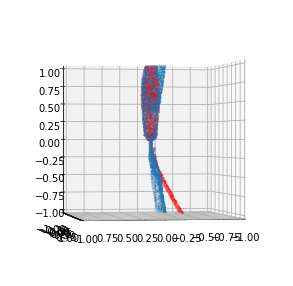

Epoch 0, train loss 51977.214844
Epoch 10, train loss 12001.730469
Epoch 20, train loss 2837.509521
Epoch 30, train loss 1835.519409
Epoch 40, train loss 1610.027588
Epoch 50, train loss 1489.102417
Epoch 60, train loss 1429.997070
Epoch 70, train loss 1385.367920
Epoch 80, train loss 1379.278198
Epoch 90, train loss 1373.078369
sampling takes: 13.097375


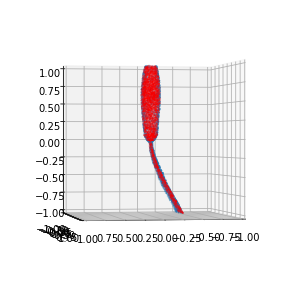

Time required for Inference : 1.505617380142212 [s]


In [58]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import sdf_meshing
from torch import nn
num_epochs = 100
n = 5600


# For each Obj
for obj_idx_, obsv in occ_data_dict.items():
  obj_idx = torch.tensor(obj_idx_).to(DEVICE)
  obj_code_i = object_code(obj_idx).squeeze()

  # For each Observation
  for def_idx_, data_i in obsv.items():

    # Initialize Contact Embedding
    cont_emb_inf_ = torch.nn.Embedding(1, 6).requires_grad_(True).to(DEVICE)
    torch.nn.init.normal_(cont_emb_inf_.weight, mean=0.0, std=0.01)
    optims = torch.optim.Adam([{'params': cont_emb_inf_.parameters(), 'lr': 3e-2}])
    cont_emb_inf = cont_emb_inf_.weight

    # Minimize Mismatch between reconstruction vs Partial Observation
    for epoch in range(num_epochs):
      reaction_force = data_i['reaction'].to(DEVICE)

      feat = classifier_model.forward_infer(cont_emb_inf, reaction_force).squeeze()
      ddecoder = Deform_Decoder(object_module, deformation_module, obj_code_i, feat, DEVICE)
      ddcoder_out = ddecoder(data_i['coords'].to(DEVICE))

      coords =ddcoder_out['model_in'].float()
      pred_sdf = ddcoder_out['model_out'].float()
      # pred_sdf_c = torch.clip(pred_sdf, -0.3, 0.3).float()

      loss_inf = pred_sdf.mean()*3e6 # + 1e2*loss_emb(cont_emb_inf)


      # visualize
      if epoch == 0 or epoch == num_epochs -1:
        source_cloud = source_cloud = sdf_meshing.create_mesh(ddecoder, filename=None, N= 300, 
                                                              output_return = True, 
                                                              verbose = False)
        
        # Random Select pointclouds to have the length
        iidx = np.random.permutation(source_cloud.shape[0])[:n]
        source_cloud = source_cloud[iidx,:]
        source_cloud = torch.tensor(source_cloud).unsqueeze(0).float()
        

        
        target_cloud = data_i['coords_gt'][:,np.where(data_i['sdf_gt']==0)[1],:].detach()
        iidx = np.random.permutation(target_cloud.size()[1])[:n]
        target_cloud = target_cloud[:,iidx,:]

        plt.figure(figsize=(5,5))
        ax = plt.axes(projection='3d')
        ax.axis("on")
        plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

        ax.scatter(source_cloud[:,:,0],source_cloud[:,:,1],source_cloud[:,:,2], s=0.04)
        ax.scatter(target_cloud[:,:,0],target_cloud[:,:,1],target_cloud[:,:,2], s=0.03, c='red')
        # ax.scatter(data_i['coords'][:,0],data_i['coords'][:,1],data_i['coords'][:,2], s=0.03, c='black')

        ax.set_xlim3d(-1,1)
        ax.set_ylim3d(-1,1)
        ax.set_zlim3d(-1,1)
        ax.grid()
        ax.view_init(0, 80)
        # plt.title(f'{deform_idx}th deformed shape from {shape_idx}th object (recons = blue, gt = red)')
        plt.show()
 

      # Update
      optims.zero_grad()
      loss_inf.backward()
      optims.step()

      if not epoch % 10:
          tqdm.write("Epoch %d, train loss %0.6f" % (epoch, loss_inf))
      
      # Measure time
      if epoch == 1:
        start = time.time()
      if epoch == num_epochs -2:
        end = time.time()

    print("Time required for Inference :", end - start, "[s]")

sampling takes: 12.291913


/content/VIRDO/sdf_meshing.py:115: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  numpy_3d_sdf_tensor, level=0.0, spacing=[voxel_size] * 3


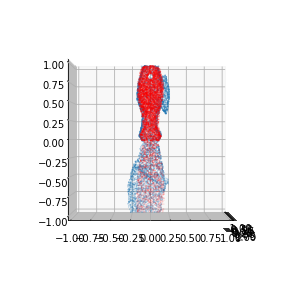

Epoch 0, train loss 59188.937500
Epoch 10, train loss 16581.105469
Epoch 20, train loss 7364.207520
Epoch 30, train loss 6352.959473
Epoch 40, train loss 5804.970215
Epoch 50, train loss 5372.601074
Epoch 60, train loss 5103.814941
Epoch 70, train loss 4974.634277
Epoch 80, train loss 4939.258301
Epoch 90, train loss 4923.091797
sampling takes: 12.441247


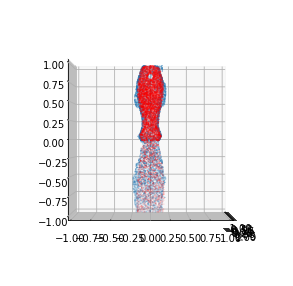

Time required for Inference : 1.4445545673370361 [s]


In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import sdf_meshing
from torch import nn
num_epochs = 100
n = 5600


# For each Obj
for obj_idx_, obsv in occ_data_dict.items():
  obj_idx = torch.tensor(obj_idx_).to(DEVICE)
  obj_code_i = object_code(obj_idx).squeeze()

  # For each Observation
  for def_idx_, data_i in obsv.items():

    # Initialize Contact Embedding
    cont_emb_inf_ = torch.nn.Embedding(1, 6).requires_grad_(True).to(DEVICE)
    torch.nn.init.normal_(cont_emb_inf_.weight, mean=0.0, std=0.001)
    optims = torch.optim.Adam([{'params': cont_emb_inf_.parameters(), 'lr': 3e-2}])
    cont_emb_inf = cont_emb_inf_.weight

    # Minimize Mismatch between reconstruction vs Partial Observation
    for epoch in range(num_epochs):
      reaction_force = data_i['reaction'].to(DEVICE)

      feat = classifier_model.forward_infer(cont_emb_inf, reaction_force).squeeze()
      ddecoder = Deform_Decoder(object_module, deformation_module, obj_code_i, feat, DEVICE)
      ddcoder_out = ddecoder(data_i['coords'].to(DEVICE))

      coords =ddcoder_out['model_in'].float()
      pred_sdf = ddcoder_out['model_out'].float()
      # pred_sdf_c = torch.clip(pred_sdf, -0.3, 0.3).float()

      loss_inf = pred_sdf.mean()*3e6 # + 1e2*loss_emb(cont_emb_inf)


      # visualize
      if epoch == 0 or epoch == num_epochs -1:
        source_cloud = source_cloud = sdf_meshing.create_mesh(ddecoder, filename=None, N= 300, 
                                                              output_return = True, 
                                                              verbose = False)
        
        # Random Select pointclouds to have the length
        iidx = np.random.permutation(source_cloud.shape[0])[:n]
        source_cloud = source_cloud[iidx,:]
        source_cloud = torch.tensor(source_cloud).unsqueeze(0).float()
        

        
        target_cloud = data_i['coords_gt'][:,np.where(data_i['sdf_gt']==0)[1],:].detach()
        iidx = np.random.permutation(target_cloud.size()[1])[:n]
        target_cloud = target_cloud[:,iidx,:]

        plt.figure(figsize=(5,5))
        ax = plt.axes(projection='3d')
        ax.axis("on")
        plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

        ax.scatter(source_cloud[:,:,0],source_cloud[:,:,1],source_cloud[:,:,2], s=0.04)
        ax.scatter(target_cloud[:,:,0],target_cloud[:,:,1],target_cloud[:,:,2], s=0.03, c='red')
        # ax.scatter(data_i['coords'][:,0],data_i['coords'][:,1],data_i['coords'][:,2], s=0.03, c='black')

        ax.set_xlim3d(-1,1)
        ax.set_ylim3d(-1,1)
        ax.set_zlim3d(-1,1)
        ax.grid()
        ax.view_init(0, 0)
        # plt.title(f'{deform_idx}th deformed shape from {shape_idx}th object (recons = blue, gt = red)')
        plt.show()
 

      # Update
      optims.zero_grad()
      loss_inf.backward()
      optims.step()

      if not epoch % 10:
          tqdm.write("Epoch %d, train loss %0.6f" % (epoch, loss_inf))
      
      # Measure time
      if epoch == 1:
        start = time.time()
      if epoch == num_epochs -2:
        end = time.time()

    print("Time required for Inference :", end - start, "[s]")

In [ ]:
dist_lst = []
dist_lst_real = []
n = 5600

np.random.seed(300)
random.seed(300)

for shape_idx in range ( len(data) ): ## YS    
    for deform_idx in data[shape_idx].keys():
        if deform_idx == "nominal":
            continue
        
        # Print every 4 scenes. Evaluating the entire dataset costs ~ 1hr.
        if deform_idx % 10 :
          continue

        data_i = data[shape_idx][deform_idx]
        shape_emb = object_code_weight[shape_idx]
        force_emb = force_code_weight[deform_idx]

        decoder = Deform_Decoder(object_module, deformation_module, shape_emb.unsqueeze(0), force_emb, DEVICE)

        source_cloud = source_cloud = create_mesh(decoder, filename=None, N= 400, output_return = True, verbose = False)
        # Random Select pointclouds to have the length
        iidx = np.random.permutation(source_cloud.shape[0])[:n]
        source_cloud = source_cloud[iidx,:]
        source_cloud = torch.tensor(source_cloud).unsqueeze(0).float()
        

        
        target_cloud = data_i['coords'][:,np.where(data_i['gt']==0)[1],:].detach()
        iidx = np.random.permutation(target_cloud.size()[1])[:n]
        target_cloud = target_cloud[:,iidx,:]


        dist= chamferDist(target_cloud, source_cloud) 
        dist_lst.append(dist.cpu().numpy()/n)

        plt.figure(figsize=(5,5))
        ax = plt.axes(projection='3d')
        ax.axis("on")
        plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

        ax.scatter(source_cloud[:,:,0],source_cloud[:,:,1],source_cloud[:,:,2], s=0.04)
        ax.scatter(target_cloud[:,:,0],target_cloud[:,:,1],target_cloud[:,:,2], s=0.03, c='red')
        ax.set_xlim3d(-1,1)
        ax.set_ylim3d(-1,1)
        ax.set_zlim3d(-1,1)
        ax.grid()
        ax.view_init(10, 80)
        plt.title(f'{deform_idx}th deformed shape from {shape_idx}th object (recons = blue, gt = red)')
        plt.show()

print( "Average CD :", np.mean(dist_lst))

# Bonus Figure: Latent Space Composition

- Color Coding of each object

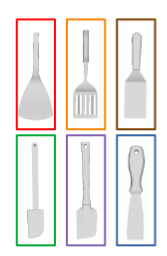

In [ ]:
!pip install plotly
!pip install umap-learn


**Task** : UMAP of Object codes

**Observation** : object codes exhibit significant separation.

In [ ]:
tot = []
label = []

for obj_idx, deform_idxs in pairs.items():
  tot.append(object_code_weight[obj_idx].unsqueeze(0))
  label.append(obj_idx)

tot = torch.cat(tot,dim=0)

import umap.umap_ as umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(tot)
embedding.shape

import matplotlib.pyplot as plt
import seaborn as sns

# Latent Space of force code distribution 
plt.figure(figsize=(4, 4))
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in label], s = 10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of force codes', fontsize=12);



**Task** : UMAP of Force codes

**Observation** : Learned force codes are distributed according
to the bending direction (+x direction / -x direction)😯

In [ ]:
tot = []
label = []

for obj_idx, deform_idxs in pairs.items():
  for deform_idx in deform_idxs:
    tot.append(force_code_weight[deform_idx])
    label.append(obj_idx)

tot = torch.cat(tot,dim=0)

import umap.umap_ as umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(tot)
embedding.shape

import matplotlib.pyplot as plt
import seaborn as sns

# Latent Space of force code distribution 
plt.figure(figsize=(4, 4))
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in label], s = 10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of force codes', fontsize=12);



**Task** : UMAP of [Force code, Shape code]. The concatenated set produces deformation field.

**Observation** : The model learns to cluster latent features by deformation properties (e.g. stiffness) that are
not directly observed or given as input 😯

In [ ]:

tot = []
label = []

for obj_idx, deform_idxs in pairs.items():
  for deform_idx in deform_idxs:
    tot.append( torch.cat([force_code_weight[deform_idx], object_code_weight[obj_idx].unsqueeze(0) ], dim = -1))
    label.append(obj_idx)

tot = torch.cat(tot,dim=0)

import umap.umap_ as umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(tot)
embedding.shape

import matplotlib.pyplot as plt
import seaborn as sns

# Latent Space of force code distribution 
plt.figure(figsize=(4, 4))
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in label], s = 10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of [force codes, object code]', fontsize=12);